In [164]:
# pip install nltk textblob
# pip install --upgrade scipy

In [48]:
import warnings
import pandas as pd
import pyspark.sql.functions as fn
from datetime import datetime
from pyspark.sql.functions import split, explode, udf, col, size, expr, to_date, avg, count, when, isnan
from pyspark.sql.types import StructType, StructField, StringType, IntegerType, DateType, BooleanType, ArrayType, TimestampType, FloatType
import nltk
from nltk.corpus import stopwords
import re
import string
from textblob import TextBlob
from datetime import date, timedelta
import pymongo
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
nltk.download('stopwords')
pd.set_option('display.max_columns', None)
warnings.filterwarnings("ignore")

[nltk_data] Downloading package stopwords to /home/hduser/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [3]:
write_config = {
    "uri": "mongodb://localhost:27017/CA2.raw_tweets?retryWrites=true&w=majority",
    "database": "CA2",
    "raw_collection": "raw_tweets",
    "modified_collection": "modified_tweets",
    "aggregates_collection": "daily_data",
    "writeConcern.w": "majority"
}

In [5]:
# Load the data from mongoDB
rawTweetsDF = spark.read\
    .format("mongodb")\
    .option("uri", write_config["uri"])\
    .option("database", write_config["database"])\
    .option("collection", write_config["raw_collection"])\
    .option("writeConcern.w", write_config["writeConcern.w"])\
    .load()

In [6]:
rawTweetsDF.printSchema()

root
 |-- _id: integer (nullable = true)
 |-- date: string (nullable = true)
 |-- flag: string (nullable = true)
 |-- tweet: string (nullable = true)
 |-- tweet_id: string (nullable = true)
 |-- user: string (nullable = true)



In [7]:
rawTweetsDF.toPandas().head()

,_id,date,flag,tweet,tweet_id,user
0,0,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,"@switchfoot http://twitpic.com/2y1zl - Awww, t...",1467810369,_TheSpecialOne_
1,1,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,is upset that he can't update his Facebook by ...,1467810672,scotthamilton
2,2,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,@Kenichan I dived many times for the ball. Man...,1467810917,mattycus
3,3,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,my whole body feels itchy and like its on fire,1467811184,ElleCTF
4,4,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,"@nationwideclass no, it's not behaving at all....",1467811193,Karoli


In [8]:
rawTweetsDF.count()

1600000

### Check for null values

In [9]:
# This will check the percentage of null values in the dataset in each columns
missingDF = rawTweetsDF.agg(*[
    (1 - (fn.count(c) / fn.count('*'))).alias(c + '_miss')
    for c in rawTweetsDF.columns
]).toPandas()

In [10]:
missingDF.melt()

,variable,value
0,_id_miss,0.0
1,date_miss,0.0
2,flag_miss,0.0
3,tweet_miss,0.0
4,tweet_id_miss,0.0
5,user_miss,0.0


### Check for duplicates

In [11]:
distinctDF = rawTweetsDF.select("tweet_id").distinct()

In [12]:
distinctDF.count()

1598315

In [13]:
rawTweetsDF.select("tweet_id").count()

1600000

In [14]:
# Retrieve a sample of duplicate records for visual purposes
notDuplicateRecordsDF = rawTweetsDF.groupBy("tweet_id").count().where("count = 1").drop("count")
duplicateRecordsDF = rawTweetsDF.join(notDuplicateRecordsDF, on="tweet_id", how="left_anti").limit(6)

In [15]:
duplicateRecordsDF.toPandas().head(6)

,tweet_id,_id,date,flag,tweet,user
0,1468053611,989,Mon Apr 06 23:28:09 PDT 2009,NO_QUERY,@hellobebe I also send some updates in plurk b...,mariejamora
1,1468053611,801280,Mon Apr 06 23:28:09 PDT 2009,NO_QUERY,@hellobebe I also send some updates in plurk b...,mariejamora
2,1468100580,1177,Mon Apr 06 23:42:57 PDT 2009,NO_QUERY,good night swetdreamss to everyonee and jare...,cristygarza
3,1468100580,801573,Mon Apr 06 23:42:57 PDT 2009,NO_QUERY,good night swetdreamss to everyonee and jare...,cristygarza
4,1468131748,1333,Mon Apr 06 23:53:22 PDT 2009,NO_QUERY,@gordonchiu You're one letter alway! Korean...,steveslee
5,1468131748,801794,Mon Apr 06 23:53:22 PDT 2009,NO_QUERY,@gordonchiu You're one letter alway! Korean...,steveslee


Since there are duplicate tweets in the dataset, we'll be removing it so that it won't cause an issue when training the model.

In [16]:
duplicatesRemovedDF = rawTweetsDF.dropDuplicates(["tweet_id"])
duplicatesRemovedDF.count()

1598315

In [17]:
rawTweetsDF = duplicatesRemovedDF;

## Data Preparation

This section shows the steps for the data preparation.

### Convert the date to Machine Readable Format
Convert the date to an array then use the array to create the date. The created timestamp will be used for aggregation in later steps.

In [21]:
# use a user defined function to convert the date and remove the time.
def convertToDate(s):
    # Split the date
    split = s.split(" ")
    # Create the timestamp
    newDate = datetime.strptime(f"{split[2]}-{split[1]}-{split[5]}", "%d-%b-%Y")
    return newDate.strftime("%Y-%m-%d")
    
convertToDateUDF = udf(convertToDate, StringType())

In [22]:
# Create a timestamp from the date array
tempDateDF = rawTweetsDF.withColumn("date_converted", convertToDateUDF(rawTweetsDF["date"]))

In [23]:
tempDateDF.select("date_converted").limit(5).toPandas().head()

,date_converted
0,2009-04-06
1,2009-04-06
2,2009-04-06
3,2009-04-06
4,2009-04-06


In [24]:
tempDateDF.select("date_converted").toPandas().tail()

,date_converted
1598310,2009-06-25
1598311,2009-06-25
1598312,2009-06-25
1598313,2009-06-25
1598314,2009-06-25


In [25]:
tempDateDF.printSchema()

root
 |-- _id: integer (nullable = true)
 |-- date: string (nullable = true)
 |-- flag: string (nullable = true)
 |-- tweet: string (nullable = true)
 |-- tweet_id: string (nullable = true)
 |-- user: string (nullable = true)
 |-- date_converted: string (nullable = true)



Getting the distinct date values reveals that there are missing dates from April 06 to June 25. This indicates that there will be data imputation for the time series data.

In [26]:
tempDateDF.select("date_converted").distinct().count()

48

In [27]:
rawTweetsDF = tempDateDF

### Tweet Cleaning and Preparation
This section cleans the tweets by removing the hashtags and user mentions. In addition, the section also computes the sentiment using nltk.

In [28]:
def decontracted(phrase):
    # specific
    phrase = re.sub(r"won\'t", "will not", phrase)
    phrase = re.sub(r"can\'t", "cannot", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

# Converts the tweet to lowercase
# Remove mentions and URLs since it doesn't contribute to the sentiment
# Removes symbols
# Removes stopwords
def processTweet (s):
    # Lowercase
    lowercaseText = s.lower()
    #Remove mentions and URLs
    processedText = re.sub(r"(?:\@|http?\://|https?\://|www)\S+", "", lowercaseText)
    processedText = " ".join(processedText.split())
    
    # Convert contractions
    processedText = " ".join(decontracted(x) for x in processedText.split())
    
    # Remove numbers
    processedText = "".join([i for i in processedText if not i.isdigit()])
    
    # Remove punctuations
    removedSymbols = processedText.translate(str.maketrans('', '', string.punctuation)) #re.sub(r"[^\w\s]", "", processedText)
    
    # Remove stopwords
#     stop = stopwords.words('english')
#     text = " ".join(x for x in processedText.split() if x not in stop)
    
    return removedSymbols

processTweet = udf(processTweet)

In [29]:
modifiedTweetDF = rawTweetsDF.withColumn("modified_tweet", processTweet(rawTweetsDF["tweet"]))

In [30]:
modifiedTweetDF.select("modified_tweet").limit(5).toPandas().head(5)

,modified_tweet
0,i was out most of the day so did not get much ...
1,meh almost lover is the exception this track g...
2,i want to go to promote gear and groove but un...
3,i cry my asian eyes to sleep at night
4,ok i am sick and spent an hour sitting in the ...


In [31]:
# Getting sentiments of the tweets
def getSentiment(s):
    return TextBlob(s).sentiment[0]

getSentimentUDF = udf(getSentiment, FloatType())

In [32]:
modifiedTweetDF = modifiedTweetDF.withColumn("sentiment", getSentimentUDF(modifiedTweetDF["modified_tweet"]))

In [33]:
modifiedTweetDF.limit(5).toPandas().head()

,_id,date,flag,tweet,tweet_id,user,date_converted,modified_tweet,sentiment
0,20,Mon Apr 06 22:20:37 PDT 2009,NO_QUERY,@alydesigns i was out most of the day so didn'...,1467813985,quanvu,2009-04-06,i was out most of the day so did not get much ...,0.350000
1,29,Mon Apr 06 22:21:04 PDT 2009,NO_QUERY,Meh... Almost Lover is the exception... this t...,1467815753,BaptisteTheFool,2009-04-06,meh almost lover is the exception this track g...,0.000000
2,31,Mon Apr 06 22:21:07 PDT 2009,NO_QUERY,@alielayus I want to go to promote GEAR AND GR...,1467815924,EmCDL,2009-04-06,i want to go to promote gear and groove but un...,0.000000
3,34,Mon Apr 06 22:21:21 PDT 2009,NO_QUERY,@HumpNinja I cry my asian eyes to sleep at night,1467816665,jsoo,2009-04-06,i cry my asian eyes to sleep at night,0.000000
4,35,Mon Apr 06 22:21:20 PDT 2009,NO_QUERY,ok I'm sick and spent an hour sitting in the s...,1467816749,scarletletterm,2009-04-06,ok i am sick and spent an hour sitting in the ...,-0.205714


Remove the columns that aren't needed in for time series analysis

In [34]:
modifiedTweetDF = modifiedTweetDF.drop("date")
modifiedTweetDF = modifiedTweetDF.drop("flag")
modifiedTweetDF = modifiedTweetDF.drop("tweet")
modifiedTweetDF = modifiedTweetDF.drop("tweet_id")
modifiedTweetDF = modifiedTweetDF.drop("user")

In [35]:
modifiedTweetDF.limit(5).toPandas()

,_id,date_converted,modified_tweet,sentiment
0,20,2009-04-06,i was out most of the day so did not get much ...,0.350000
1,29,2009-04-06,meh almost lover is the exception this track g...,0.000000
2,31,2009-04-06,i want to go to promote gear and groove but un...,0.000000
3,34,2009-04-06,i cry my asian eyes to sleep at night,0.000000
4,35,2009-04-06,ok i am sick and spent an hour sitting in the ...,-0.205714


Save the modified tweet dataframe to mongoDB. This will serve as a checkpoint incase there will be some modifications to the modified tweets.

In [36]:
# modifiedTweetDF.write\
#     .format("mongodb")\
#     .mode("append")\
#     .option("uri", write_config["uri"])\
#     .option("database", write_config["database"])\
#     .option("collection", "modified_tweets")\
#     .option("writeConcern.w", write_config["writeConcern.w"])\
#     .save()

2023-11-12 02:39:30,873 WARN util.CaseInsensitiveStringMap: Converting duplicated key writeconcern.w into CaseInsensitiveStringMap.


In [37]:
modifiedTweetDF.toPandas().describe()

,_id,sentiment
count,1.598315e+06,1.598315e+06
mean,7.995771e+05,9.309262e-02
std,4.618790e+05,3.288140e-01
min,0.000000e+00,-1.000000e+00
25%,3.995785e+05,0.000000e+00
50%,7.991570e+05,0.000000e+00
75%,1.199576e+06,2.716667e-01
max,1.599999e+06,1.000000e+00


In [38]:
modifiedTweetDF.select("modified_tweet", "sentiment").where("sentiment = -1").show()

+--------------------+---------+
|      modified_tweet|sentiment|
+--------------------+---------+
|i treated myself ...|     -1.0|
|i see you escaped...|     -1.0|
|nawww take me to ...|     -1.0|
|roxy that is hyst...|     -1.0|
|work is so boring...|     -1.0|
|is warning you if...|     -1.0|
|on my way to the ...|     -1.0|
|well that is me g...|     -1.0|
|i wish i had a ca...|     -1.0|
|twitter is gettin...|     -1.0|
|hey hey hey i dnt...|     -1.0|
|the electricity s...|     -1.0|
|i am a terrible s...|     -1.0|
|what makes iago e...|     -1.0|
|alright there was...|     -1.0|
|psh i burned my e...|     -1.0|
|ohh that must be ...|     -1.0|
|tweets are quite ...|     -1.0|
|doing my astrolog...|     -1.0|
|that would be hys...|     -1.0|
+--------------------+---------+
only showing top 20 rows



### Aggregating tweets

In this section, MongoDB was used to aggregate the data since PySpark is slow in aggregating the data. Indexes for date and sentiment were created in MonogDB to make querying faster.

In [55]:
tempPanda = modifiedTweetDF.select("date_converted").toPandas()

In [39]:
client = pymongo.MongoClient("localhost", 27017)
db = client.CA2

In [92]:
pipeline = [
    { 
        "$facet": {
            "aveSenti": [
                { "$group": { "_id": "$date_converted", "tweet_count": { "$sum": 1 }, "average_sentiment": { "$avg": "$sentiment" } } },
                { "$sort": { "_id": 1 } }
            ],
            "posiSenti": [
                { "$match": { "sentiment": { "$gt": 0 } } },
                { "$group": { "_id": "$date_converted", "positive_senti_count": { "$sum": 1 } } },
                { "$sort": { "_id": 1 } }
            ],
            "negaSenti": [
                { "$match": { "sentiment": { "$lt": 0 } } },
                { "$group": { "_id": "$date_converted", "negative_senti_count": { "$sum": 1 } } },
                { "$sort": { "_id": 1 } }
            ],
            "neuSenti": [
                { "$match": { "sentiment": { "$eq": 0 } } },
                { "$group": { "_id": "$date_converted", "neutral_senti_count": { "$sum": 1 } } },
                { "$sort": { "_id": 1 } }
            ],
            
        } 
    }
]
# import pprint
# pprint.pprint(list())
databaseResponse = list(db.modified_tweets.aggregate(pipeline))

In [94]:
averageSentiment = databaseResponse[0]["aveSenti"];
positiveSentiment = databaseResponse[0]["posiSenti"];
negativeSentiment = databaseResponse[0]["negaSenti"];
neutralSentiment = databaseResponse[0]["neuSenti"];

In [95]:
def getSentiForDay(currDate, sentiPool):
    res = list(filter(lambda s: s['_id'] == currDate, sentiPool))
    return res[0] if len(res) > 0 else None

# Loop through the dates from the start date to the end date of the dataset
start_date = datetime.strptime(tempPanda["date_converted"][0], "%Y-%m-%d").date()
end_date = datetime.strptime(tempPanda["date_converted"][len(tempPanda) - 1], "%Y-%m-%d").date()
delta = timedelta(days=1)
data = []
while start_date <= end_date:
    currDate = start_date.strftime("%Y-%m-%d")
    currAveSenti = getSentiForDay(currDate, averageSentiment)
    currPosiSenti = getSentiForDay(currDate, positiveSentiment)
    currNegaSenti = getSentiForDay(currDate, negativeSentiment)
    currNeuSenti = getSentiForDay(currDate, neutralSentiment)
#     print(currAveSenti, currPosiSenti, currNegaSenti, currNeuSenti)
    
    tweetCount = np.nan
    aveSenti = np.nan
    posiSenti = np.nan
    negaSenti = np.nan
    neuSenti = np.nan
    
    if(currAveSenti):
        tweetCount = currAveSenti["tweet_count"]
        aveSenti = currAveSenti["average_sentiment"]
   
    if(currPosiSenti):
        posiSenti = currPosiSenti["positive_senti_count"]
    
    if(currNegaSenti):
        negaSenti = currNegaSenti["negative_senti_count"]
        
    if(currNeuSenti):
        neuSenti = currNeuSenti["neutral_senti_count"]
        
    row = [currDate, tweetCount, aveSenti, posiSenti, posiSenti/tweetCount if posiSenti else np.nan, negaSenti, negaSenti/tweetCount if negaSenti else np.nan, neuSenti, neuSenti/tweetCount if neuSenti else np.nan]
    data.append(row)
    start_date += delta

In [96]:
columns = ["date", "tweet_count", "average_sentiment", "positive_count", "positive_ratio", "negative_count", "negative_ratio", "neutral_count", "neutral_ratio"]

In [97]:
tsPDF = pd.DataFrame(data, columns=columns)
tsPDF.iteritems = tsPDF.items

In [98]:
tsSDF = spark.createDataFrame(tsPDF)

In [99]:
tsSDF.write\
    .format("mongodb")\
    .mode("append")\
    .option("uri", write_config["uri"])\
    .option("database", write_config["database"])\
    .option("collection", write_config["aggregates_collection"])\
    .option("writeConcern.w", write_config["writeConcern.w"])\
    .save()

2023-11-12 03:30:02,326 WARN util.CaseInsensitiveStringMap: Converting duplicated key writeconcern.w into CaseInsensitiveStringMap.


To-Do:
- Graph the number of tweets
- Impute data

In [4]:
# This is a code for loading the daily data. 
# The daily data is already saved to MongoDB as a sort of checkpoint 
# in case the EDA got interrupted or was stopped.
tsSDF = spark.read\
    .format("mongodb")\
    .option("uri", write_config["uri"])\
    .option("database", write_config["database"])\
    .option("collection", write_config["aggregates_collection"])\
    .option("writeConcern.w", write_config["writeConcern.w"])\
    .load()\
    .sort("date")

In [38]:
tsSDF.printSchema()

root
 |-- _id: string (nullable = true)
 |-- average_sentiment: double (nullable = true)
 |-- date: string (nullable = true)
 |-- negative_count: double (nullable = true)
 |-- negative_ratio: double (nullable = true)
 |-- neutral_count: double (nullable = true)
 |-- neutral_ratio: double (nullable = true)
 |-- positive_count: double (nullable = true)
 |-- positive_ratio: double (nullable = true)
 |-- tweet_count: double (nullable = true)



In [56]:
# This will check the percentage of null values in the dataset in each columns
NaNPercentage = (tsSDF.filter(isnan(col("average_sentiment"))).count() / tsSDF.count()) * 100
TotalMissingDates = tsSDF.filter(isnan(col("average_sentiment"))).count()
TotalDates = tsSDF.count()

In [57]:
NaNPercentage, TotalMissingDates, TotalDates

(40.74074074074074, 33, 81)

In [6]:
tempPanda = tsSDF.toPandas()

In [7]:
def createLinePlot(dataSet, title, legend = []):
    plt.rcParams['figure.figsize']=(15,7)
    plt.plot(dataSet)
    plt.xticks(dataSet.index[::10])
    plt.title(title)
    plt.legend(legend)
    plt.show()


In [8]:
tempPanda.head()

,_id,average_sentiment,date,negative_count,negative_ratio,neutral_count,neutral_ratio,positive_count,positive_ratio,tweet_count
0,655046ba3593c51817cc499f,0.098418,2009-04-06,691.0,0.206023,1161.0,0.346154,1502.0,0.447823,3354.0
1,655046ba3593c51817cc49a0,0.103523,2009-04-07,3469.0,0.200648,6113.0,0.353577,7707.0,0.445775,17289.0
2,655046ba3593c51817cc49a1,NaN,2009-04-08,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,655046ba3593c51817cc49a2,NaN,2009-04-09,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,655046ba3593c51817cc49a3,NaN,2009-04-10,NaN,NaN,NaN,NaN,NaN,NaN,NaN


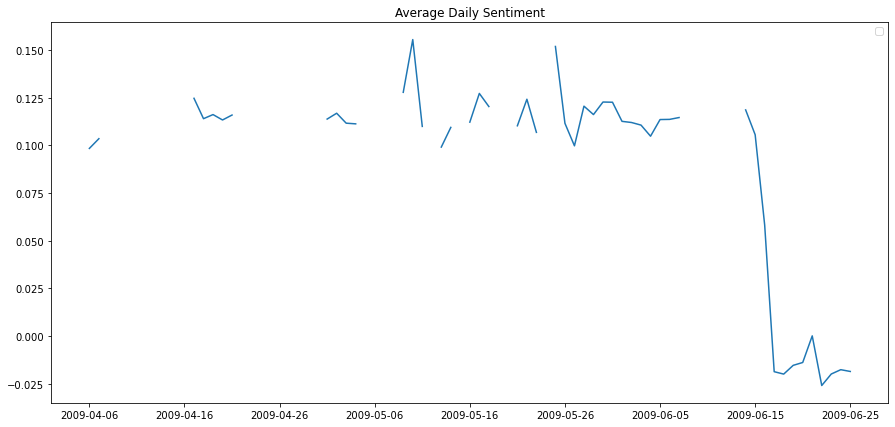

In [10]:
tempAve = tempPanda[["date", "average_sentiment"]]
tempAve.set_index("date", inplace=True)
createLinePlot(tempAve, "Average Daily Sentiment")

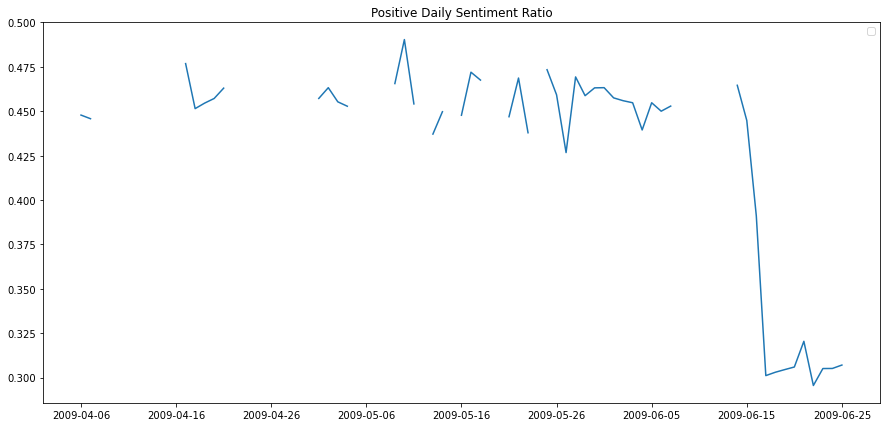

In [11]:
tempPosi = tempPanda[["date", "positive_ratio"]]
tempPosi.set_index("date", inplace=True)
createLinePlot(tempPosi, "Positive Daily Sentiment Ratio")

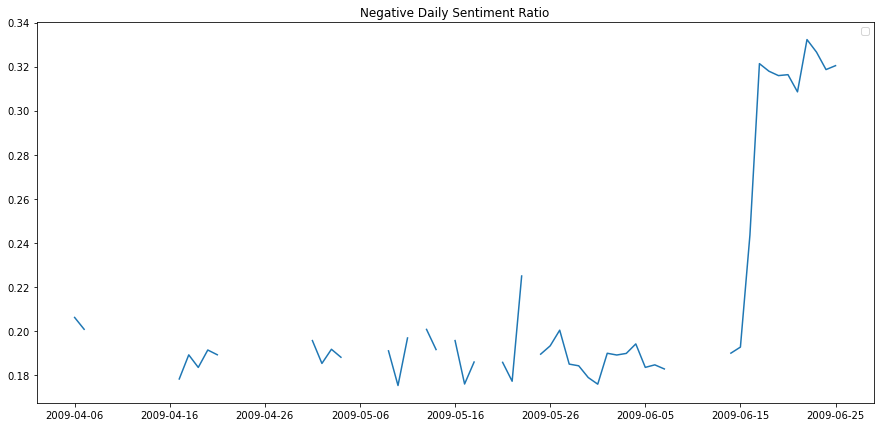

In [12]:
tempNega = tempPanda[["date", "negative_ratio"]]
tempNega.set_index("date", inplace=True)
createLinePlot(tempNega, "Negative Daily Sentiment Ratio")

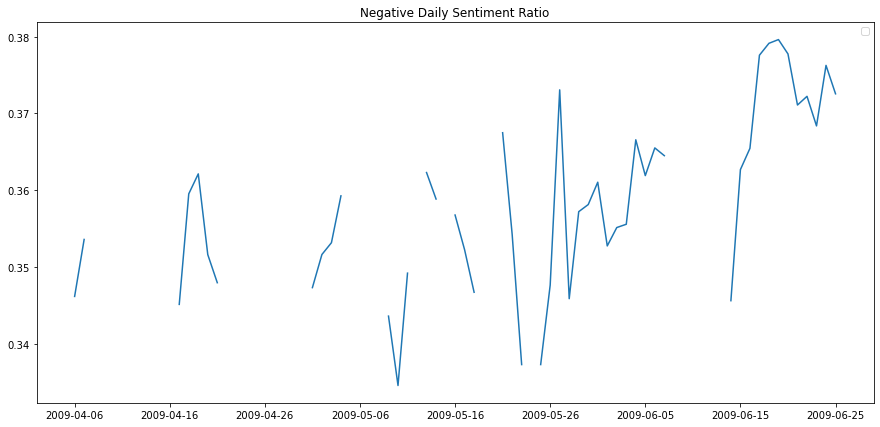

In [13]:
tempNeu = tempPanda[["date", "neutral_ratio"]]
tempNeu.set_index("date", inplace=True)
createLinePlot(tempNeu, "Negative Daily Sentiment Ratio")

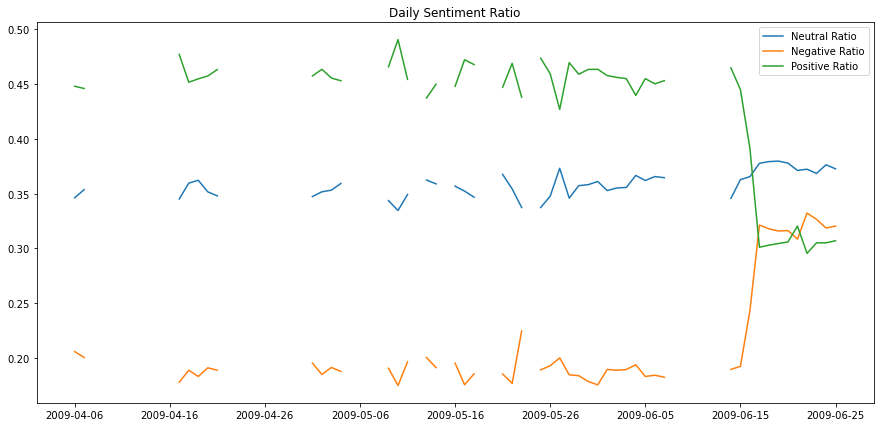

In [14]:
tempAllRatio = tempPanda[["date", "neutral_ratio", "negative_ratio", "positive_ratio"]]
tempAllRatio.set_index("date", inplace=True)
createLinePlot(tempAllRatio, "Daily Sentiment Ratio", ["Neutral Ratio", "Negative Ratio", "Positive Ratio"])

Spline with order 3 was used because this is commonly used for interpolation tasks. Higher interpolation order tends to overfit.

In [122]:
def splineInterpolate(column, newColumnName, dataset):
    dataset[newColumnName] = dataset[column].interpolate(method='spline', order=3)
    tempDS = tempPanda[["date", newColumnName, column,]]
    tempDS.set_index("date", inplace=True)
    return tempDS 

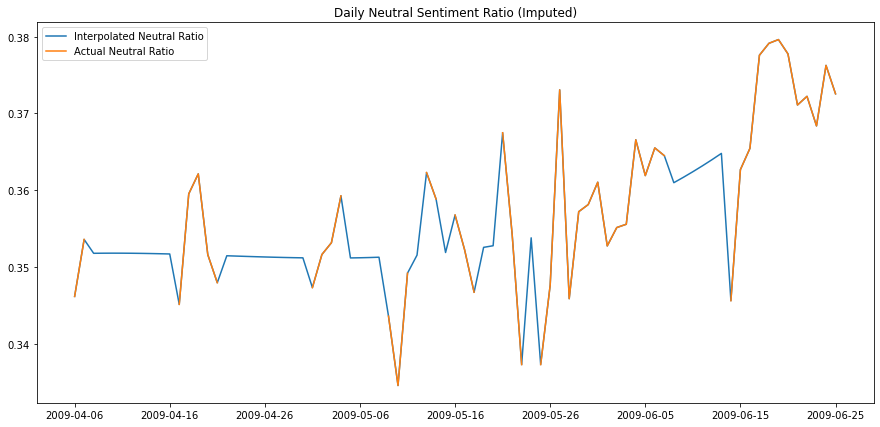

In [123]:
# tempPanda["neutral_interpolated"] = tempPanda["neutral_ratio"].interpolate(method='spline', order=3)
# tempNeuInterpolated = tempPanda[["date", "neutral_interpolated", "neutral_ratio",]]
# tempNeuInterpolated.set_index("date", inplace=True)
tempNeuInterpolated = splineInterpolate("neutral_ratio", "neutral_interpolated", tempPanda)
createLinePlot(tempNeuInterpolated, "Daily Neutral Sentiment Ratio (Imputed)", ["Interpolated Neutral Ratio", "Actual Neutral Ratio"])

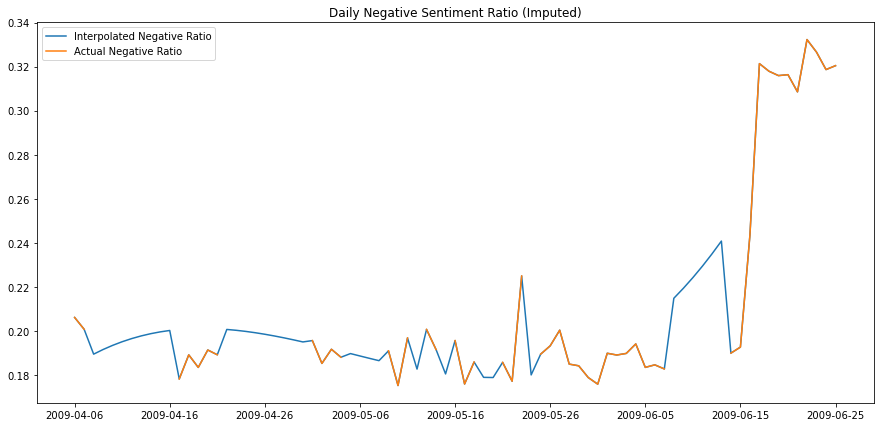

In [124]:
# tempPanda["negative_interpolated"] = tempPanda["negative_ratio"].interpolate(method='akima')
# tempNeuInterpolated = tempPanda[["date", "negative_interpolated", "negative_ratio",]]
# tempNeuInterpolated.set_index("date", inplace=True)
tempNegInterpolated = splineInterpolate("negative_ratio", "negative_interpolated", tempPanda)
createLinePlot(tempNegInterpolated, "Daily Negative Sentiment Ratio (Imputed)", ["Interpolated Negative Ratio", "Actual Negative Ratio"])

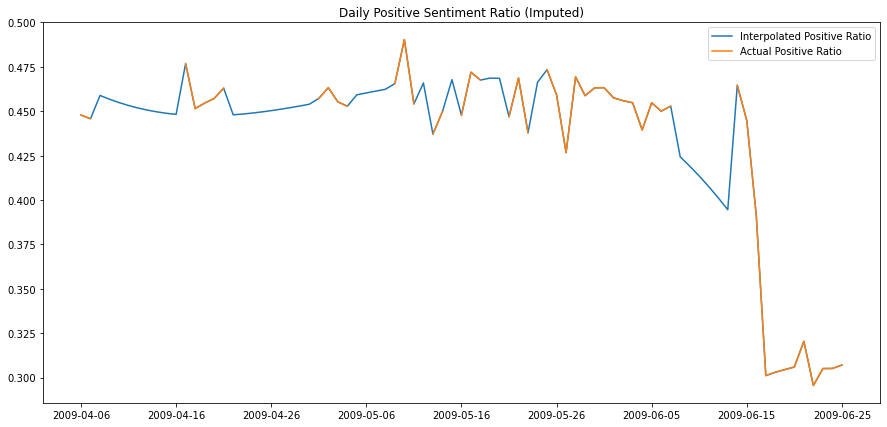

In [125]:
tempPosInterpolated = splineInterpolate("positive_ratio", "positive_interpolated", tempPanda)
createLinePlot(tempPosInterpolated, "Daily Positive Sentiment Ratio (Imputed)", ["Interpolated Positive Ratio", "Actual Positive Ratio"])

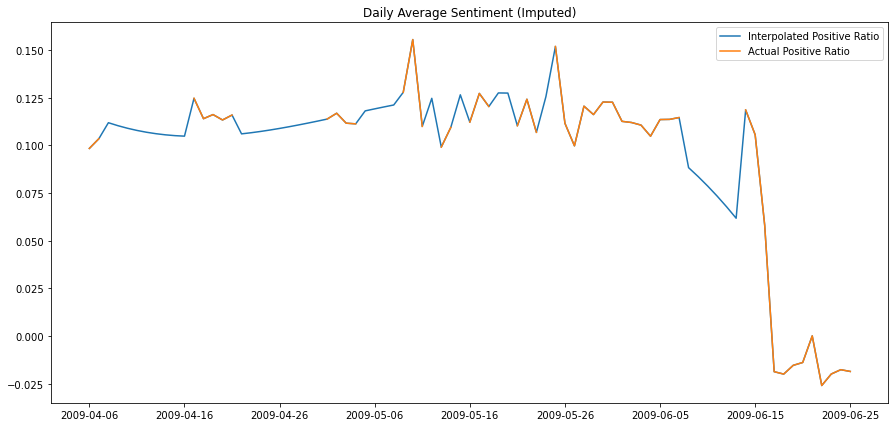

In [126]:
tempPosInterpolated = splineInterpolate("average_sentiment", "average_sentiment_interpolated", tempPanda)
createLinePlot(tempPosInterpolated, "Daily Average Sentiment (Imputed)", ["Interpolated Positive Ratio", "Actual Positive Ratio"])

In [127]:
tempPanda.head()

,_id,average_sentiment,date,negative_count,negative_ratio,neutral_count,neutral_ratio,positive_count,positive_ratio,tweet_count,neutral_interpolated,neutral_akima_interpolated,negative_interpolated,positive_interpolated,average_sentiment_interpolated
0,655046ba3593c51817cc499f,0.098418,2009-04-06,691.0,0.206023,1161.0,0.346154,1502.0,0.447823,3354.0,0.346154,0.346154,0.206023,0.447823,0.098418
1,655046ba3593c51817cc49a0,0.103523,2009-04-07,3469.0,0.200648,6113.0,0.353577,7707.0,0.445775,17289.0,0.353577,0.353577,0.200648,0.445775,0.103523
2,655046ba3593c51817cc49a1,NaN,2009-04-08,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.351773,0.356509,0.189355,0.458872,0.111898
3,655046ba3593c51817cc49a2,NaN,2009-04-09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.351786,0.356737,0.191472,0.456742,0.110344
4,655046ba3593c51817cc49a3,NaN,2009-04-10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.351791,0.354963,0.193350,0.454860,0.109000


In [148]:
import pandas as pd
from sklearn.impute import KNNImputer
# https://www.techscience.com/cmc/v70n1/44403/pdf
def KNNImpute(column, newColumn, dataset):
    tempData = dataset[["date", column]]
    tempData.set_index("date", inplace=True)
    knn_imputer = KNNImputer(n_neighbors=5)
    imputed = knn_imputer.fit_transform(tempData)
    df_imputed_subset = pd.DataFrame(imputed, columns=[column])
    dataset[newColumn] = df_imputed_subset
    return df_imputed_subset

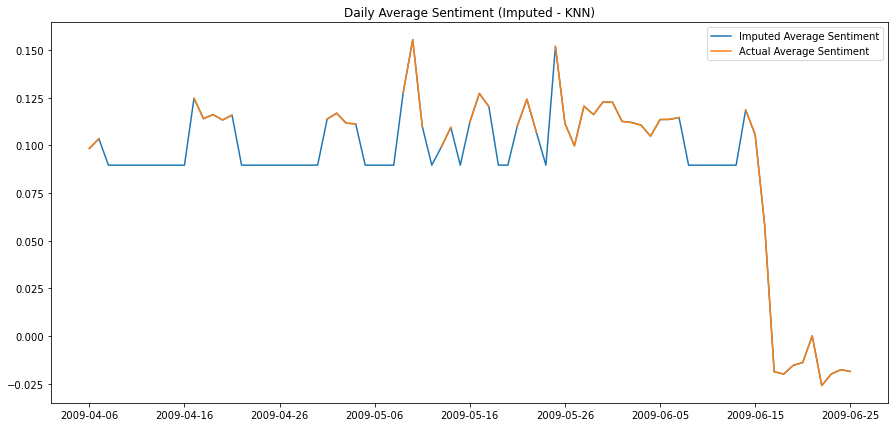

In [162]:
kNNAveDF = KNNImpute("average_sentiment", "average_sentiment_knn", tempPanda)
tempDS = tempPanda[["date", "average_sentiment_knn", "average_sentiment",]]
tempDS.set_index("date", inplace=True)
createLinePlot(tempDS, "Daily Average Sentiment (Imputed - KNN)", ["Imputed Average Sentiment", "Actual Average Sentiment"])

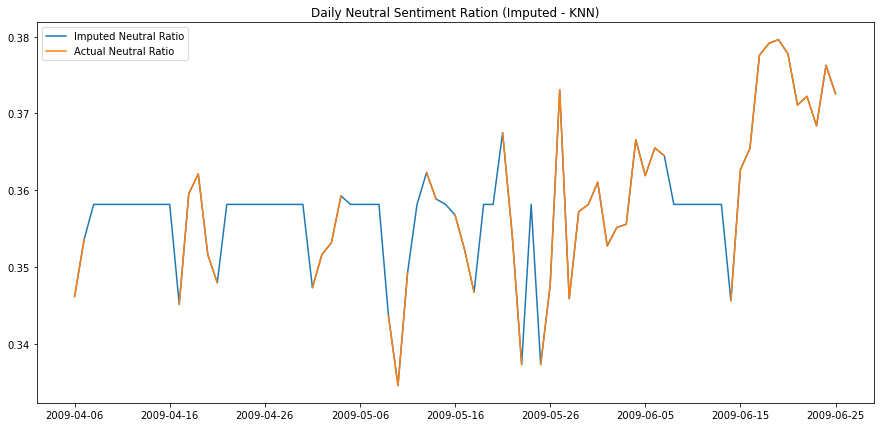

In [161]:
kNNAveDF = KNNImpute("neutral_ratio", "neutral_ratio_knn", tempPanda)
tempDS = tempPanda[["date", "neutral_ratio_knn", "neutral_ratio",]]
tempDS.set_index("date", inplace=True)
createLinePlot(tempDS, "Daily Neutral Sentiment Ration (Imputed - KNN)", ["Imputed Neutral Ratio", "Actual Neutral Ratio"])

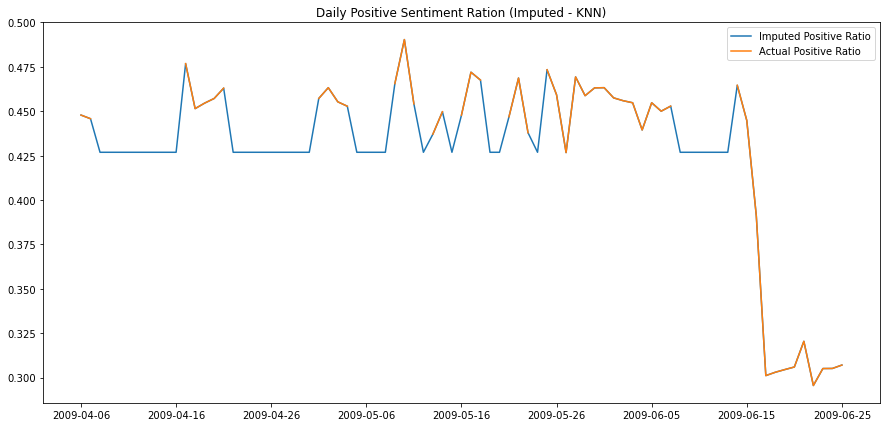

In [159]:
kNNAveDF = KNNImpute("positive_ratio", "positive_ratio_knn", tempPanda)
tempDS = tempPanda[["date", "positive_ratio_knn", "positive_ratio",]]
tempDS.set_index("date", inplace=True)
createLinePlot(tempDS, "Daily Positive Sentiment Ration (Imputed - KNN)", ["Imputed Positive Ratio", "Actual Positive Ratio"])

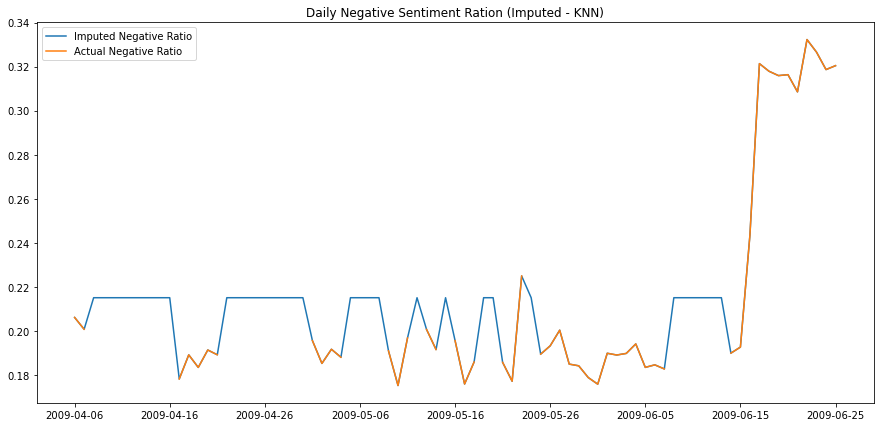

In [160]:
kNNAveDF = KNNImpute("negative_ratio", "negative_ratio_knn", tempPanda)
tempDS = tempPanda[["date", "negative_ratio_knn", "negative_ratio",]]
tempDS.set_index("date", inplace=True)
createLinePlot(tempDS, "Daily Negative Sentiment Ration (Imputed - KNN)", ["Imputed Negative Ratio", "Actual Negative Ratio"])

In [171]:
tempPanda.drop("neutral_akima_interpolated", inplace=True, axis=1)
tempPanda.head()

,_id,average_sentiment,date,negative_count,negative_ratio,neutral_count,neutral_ratio,positive_count,positive_ratio,tweet_count,neutral_interpolated,negative_interpolated,positive_interpolated,average_sentiment_interpolated,average_sentiment_knn,neutral_ratio_knn,positive_ratio_knn,negative_ratio_knn
0,655046ba3593c51817cc499f,0.098418,2009-04-06,691.0,0.206023,1161.0,0.346154,1502.0,0.447823,3354.0,0.346154,0.206023,0.447823,0.098418,0.098418,0.346154,0.447823,0.206023
1,655046ba3593c51817cc49a0,0.103523,2009-04-07,3469.0,0.200648,6113.0,0.353577,7707.0,0.445775,17289.0,0.353577,0.200648,0.445775,0.103523,0.103523,0.353577,0.445775,0.200648
2,655046ba3593c51817cc49a1,NaN,2009-04-08,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.351773,0.189355,0.458872,0.111898,0.089641,0.358143,0.426873,0.214985
3,655046ba3593c51817cc49a2,NaN,2009-04-09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.351786,0.191472,0.456742,0.110344,0.089641,0.358143,0.426873,0.214985
4,655046ba3593c51817cc49a3,NaN,2009-04-10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.351791,0.193350,0.454860,0.109000,0.089641,0.358143,0.426873,0.214985


In [172]:
tempPanda.iteritems = tempPanda.items
newlyImputedDF = spark.createDataFrame(tempPanda)

In [173]:
newlyImputedDF.write\
    .format("mongodb")\
    .mode("append")\
    .option("uri", write_config["uri"])\
    .option("database", write_config["database"])\
    .option("collection", "daily_data_imputed")\
    .option("writeConcern.w", write_config["writeConcern.w"])\
    .save()

2023-11-12 22:09:27,129 WARN util.CaseInsensitiveStringMap: Converting duplicated key writeconcern.w into CaseInsensitiveStringMap.
